t = 0
t = 1
t = 2
t = 3
t = 4
t = 5
t = 6
t = 7
t = 8
t = 9


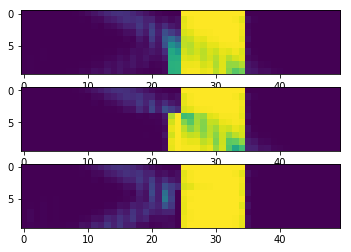

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import pdb
import copy
import MPS
import math


#plt.set_cmap('plasma')

def apply_gaussian_particle(gamma, lmbda, x0, width, velocity, empty_index, particle_index):

	particle_range = range(x0 - 2 * width, x0 + 2 * width)
	
	bottom = particle_range[0]

	amplitudes = np.array( [ np.exp( -(x - x0)**2 / (2 * width**2)) * np.exp(1j * velocity * (x - x0)) for x in particle_range] )
	amplitudes = amplitudes / np.sqrt( np.sum(amplitudes * np.conj(amplitudes)) )
		
	probs = np.abs( amplitudes * np.conj(amplitudes))
	phases = amplitudes / np.abs(amplitudes)

	#To construct our "wavefunction",
	#Place single particle at x = 0
	#apply switching gates with certain probability,
	#then impose the desired phases

	gamma[bottom][0][0][empty_index] = 0
	gamma[bottom][0][0][particle_index] = 1
	
	site_dim = gamma[0].shape[2]

	switching_gate = np.zeros((site_dim, site_dim, site_dim, site_dim))
	
	switching_gate[empty_index][empty_index][empty_index][empty_index] = 1
	switching_gate[particle_index][particle_index][particle_index][particle_index] = 1


	for x in particle_range:
	
		#Our gate switches particles with probability p
		p = probs[(x - bottom)] / np.sum(probs[(x - bottom):])
		
		switching_gate[empty_index][particle_index][empty_index][particle_index] = np.sqrt(p)
		
		switching_gate[particle_index][empty_index][particle_index][empty_index] = np.sqrt(p)
		
		switching_gate[empty_index][particle_index][particle_index][empty_index] = np.sqrt(1 - p)
		
		switching_gate[particle_index][empty_index][empty_index][particle_index] = np.sqrt(1 - p)
		
		gamma[x], lmbda[x], gamma[x + 1] = \
			MPS.apply_double_gate(switching_gate, gamma[x], lmbda[x], gamma[x + 1], lmbda[x - 1], lmbda[x + 1])
		
	phase_gate = np.zeros((site_dim, site_dim), dtype = np.complex_)
	phase_gate[empty_index][empty_index] = 1
	for x in particle_range:

		phase_gate[particle_index][particle_index] = phases[x - bottom]	
		gamma[x] = MPS.apply_single_gate(phase_gate, gamma[x])
		
	return gamma, lmbda


#p_density only used in Fermi Hubbard model
def run_sim_NNN(H_NN,H_NNN, init_gamma, init_lmbda, bond_dim, site_dim, L, T, p_density):
	
	delta = 0.25
	
	#j is the imaginary unit
	U_NN_local = linalg.expm( -1j * delta * H_NN)
	U_NN_local_tens = MPS.split_axes(U_NN_local, 0, site_dim, site_dim)
	U_NN_local_tens = MPS.split_axes(U_NN_local_tens, 2, site_dim, site_dim)
	U_swap = np.zeros((4,4),dtype = np.complex_)
	U_swap[0,0] = 1
	U_swap[1,2] = 1
	U_swap[2,1] = 1
	U_swap[3,3] = 1
	U_swap_tens = MPS.split_axes(U_swap, 0, site_dim, site_dim)
	U_swap_tens = MPS.split_axes(U_swap_tens, 2, site_dim, site_dim)
	U_NNN_local = linalg.expm( -1j * delta * H_NNN)
	U_NNN_local_tens = MPS.split_axes(U_NNN_local, 0, site_dim, site_dim)
	U_NNN_local_tens = MPS.split_axes(U_NNN_local_tens, 2, site_dim, site_dim)
	P_up = np.zeros((2,2),dtype = np.complex_)
	P_up[1,1] = 1
	P_down = np.zeros((2,2),dtype = np.complex_)
	P_down[0,0] = 1

	preferred_site = 24
	preferred_time = 4

	
	gamma = init_gamma #The array of MPS matrices, one for each lattice site.  This is the "state"
	lmbda = init_lmbda #These are the Schmidt coefficients,	 indexed by the bond index. It's basically just weights. The sum of norm squared of this vector is unity.
	
	beta_list, lmbda_list = MPS.convert_to_beta(gamma, lmbda)
	
	particle_densities = np.zeros((T, L))
	particle_densities_branches = np.zeros((2, T, L))
	
	T = float(T)

	def implement_double_gate(U_tens,kk):
		beta_list[kk], lmbda_list[kk], beta_list[kk + 1] = \
				MPS.apply_double_gate_beta( U_tens, lmbda_list[kk - 1], beta_list[kk], beta_list[kk + 1])
	
	for t in range(int(T/delta)):

		#print(np.array(lmbda).real)
		t_1 = math.floor(t * delta)
		if  t * delta - t_1 < delta:
			
			gamma, lmbda = MPS.convert_from_beta(beta_list, lmbda_list)
			
			print ("t = {}".format(t_1))
			particle_densities[t_1] = np.abs(np.array([MPS.measurement(particle_density, gamma[i], lmbda[i - 1], lmbda[i]) for i in range(L)], dtype = np.complex_))
			if t * delta < preferred_time:
				particle_densities_branches[0,t_1]=particle_densities[t_1].copy()
				particle_densities_branches[1,t_1]=particle_densities[t_1].copy()
			else:
				gamma_up = gamma.copy()
				lmbda_up = lmbda.copy()
				gamma_down = gamma.copy()
				lmbda_down = lmbda.copy()
				gamma_up, lmbda_up = MPS.project_and_update(gamma_up, lmbda_up, P_up, preferred_site)
				gamma_down, lmbda_down = MPS.project_and_update(gamma_down, lmbda_down, P_down, preferred_site)
				particle_densities_branches[0,t_1] = np.abs(np.array([MPS.measurement(particle_density, gamma_up[i],   lmbda_up[i - 1], lmbda_up[i]) for i in range(L)], dtype = np.complex_))
				particle_densities_branches[1,t_1] = np.abs(np.array([MPS.measurement(particle_density, gamma_down[i], lmbda_down[i - 1], lmbda_down[i]) for i in range(L)], dtype = np.complex_))

		
		#First do the even sites, then odd sites, in accordance with Vidal's paper
		for k in range(0,int(L/2)):
			#gamma[2 * k], lmbda[2 * k], gamma[2 * k + 1] = \
			#	MPS.apply_double_gate( U_NN_local_tens, gamma[2 * k], lmbda[2 * k], gamma[2 * k + 1], lmbda[2 * k - 1], lmbda[2 * k + 1])
			implement_double_gate(U_NN_local_tens, 2*k)

		for k in range(0,int((L-1)/2)):
			#gamma[2 * k + 1], lmbda[2 * k + 1], gamma[2 * k + 2] = \
				#MPS.apply_double_gate( U_NN_local_tens, gamma[2 * k + 1], lmbda[2 * k + 1], gamma[2 * k + 2], lmbda[2 * k], lmbda[2 * k + 2])
			implement_double_gate(U_NN_local_tens, 2*k+1)

		#Now let's try some next-nearest neighbor stuff
		#I have no idea if this is accurate or stable.  Just making it up
		for k in range(0,int((L-1)/2)):
			implement_double_gate(U_swap_tens,      2*k+1)
			implement_double_gate(U_NNN_local_tens, 2*k)
			implement_double_gate(U_swap_tens,      2*k+1)

		for k in range(0,int((L-2)/2)):
			implement_double_gate(U_swap_tens,      2*k+2)
			implement_double_gate(U_NNN_local_tens, 2*k+1)
			implement_double_gate(U_swap_tens,      2*k+2)

	
	#project onto presence of particle.
	P = np.zeros((2,2), dtype = np.complex_)
	P[1][1] = 1
	#gamma, lmbda = MPS.project_and_update(gamma, lmbda, P,  
	
	fig = plt.figure()
	ax1 = fig.add_subplot(311)
	imgplot = plt.imshow(particle_densities)
	ax2 = fig.add_subplot(312)
	imgplot = plt.imshow(particle_densities_branches[0])
	ax3 = fig.add_subplot(313)
	imgplot = plt.imshow(particle_densities_branches[1])

	plt.show()
	return gamma, lmbda

# a list is in square brackets, e.g., [1,2,3]
# a tuple is in parentheses, e.g., (1,2,3)
# List is mutable and tuple is immutable.

##########################  SPIN-POLARIZED FERMIONS  ##########################
fermion_L = 50
fermion_bond_dim = 16
fermion_site_dim = 2

#Creation operator
C = np.zeros((2,2))
C[0][1] = 1

#C is an narray (numpy n-dim array type), and .T is one of the transpose methods)
##conj is the complex conjugate.  So np.conj(C.T) conjugate transpose
#i.e, this is annihilation operator
D = np.conj(C.T)

I = np.array( [[1,0],[0,1]] )

#Total H is this applied to each pair of qubits. Parameterized by V and t_0
t_0 = 1
V = t_0 * 10
V_2 = 1.2
#MPS.matr_tensor tensors the matrices together, i.e., Kronecker product
# we are tensoring together because this is the Hamiltonian for two (neighboring) lattice sites.  matr_tensor(C, D) creates an excitation on one site and annihilates it on the other
# on the other hand, np.dot(C,D) is just the number operator  (but maybe off by 1 in this definition?)
#H_fermion =  t_0 * (MPS.matr_tensor(C, D) + MPS.matr_tensor(D,C)) + V * MPS.matr_tensor ( ( np.dot(C,D) - 1./2 * I),  ( np.dot(C,D) - 1./2 * I) )
#Lets do NN = nearest enighbor, NNN= next-nearest neighbor
H_fermion_NN =  t_0 * (MPS.matr_tensor(C, D) + MPS.matr_tensor(D,C)) + V * MPS.matr_tensor ( ( np.dot(C,D) - 1./2 * I),  ( np.dot(C,D) - 1./2 * I) )
H_fermion_NNN = V_2 * MPS.matr_tensor ( ( np.dot(C,D) - 1./2 * I),  ( np.dot(C,D) - 1./2 * I) )


particle_density = np.array([[0,0],[0,1]], dtype = np.complex_)

fermion_gamma = [np.zeros((fermion_bond_dim, fermion_bond_dim, fermion_site_dim), dtype = np.complex_) for i in range(fermion_L)]
fermion_lmbda = [np.zeros((fermion_bond_dim)) for i in range(fermion_L)]

for lmbda in fermion_lmbda:
	lmbda[0] = 1
	
for gamma in fermion_gamma:
	gamma[0][0][0] = 1

#fermion_gamma[0][0][0] = [0,-1j]

#Place a wall of particles

for i in range(25,35):
	fermion_gamma[i][0][0] = [0,1]

fermion_gamma, fermion_lmbda = apply_gaussian_particle(fermion_gamma, fermion_lmbda, 15, 4, -np.pi/2, 0, 1)

T = 10
fermion_gamma, fermion_lmbda = run_sim_NNN(H_fermion_NN,H_fermion_NNN, fermion_gamma, fermion_lmbda, fermion_bond_dim, fermion_site_dim, fermion_L, T, particle_density)

fermion_transfer = [ np.einsum('ayi,ayi->ay', f_g, np.conj(f_g)) for f_g in fermion_gamma]

eps = 1e-2

n_blocks = MPS.num_blocks_list(fermion_gamma, fermion_lmbda, eps)

print(n_blocks)

print([i for i in range(len(n_blocks)) if n_blocks[i] > 1])

block_indices = [i for i in range(len(n_blocks)) if n_blocks[i] == 2]
print(block_indices)

for ind in block_indices:

    branches = MPS.block_decomposition(fermion_gamma, fermion_lmbda, ind, eps)

    branch_1_gamma, branch_1_lmbda = branches[0]
    branch_2_gamma, branch_2_lmbda = branches[1]

    branch_1_densities = np.abs(np.array([MPS.measurement(particle_density, branch_1_gamma[i], branch_1_lmbda[i - 1], branch_1_lmbda[i]) for i in range(fermion_L)], dtype = np.complex_))
    branch_2_densities = np.abs(np.array([MPS.measurement(particle_density, branch_2_gamma[i], branch_2_lmbda[i - 1], branch_2_lmbda[i]) for i in range(fermion_L)], dtype = np.complex_))

    print(ind)
    plt.imshow(np.array([branch_1_densities]))
    plt.show()
    plt.imshow(np.array([branch_2_densities]))
    plt.show()

print("Block-finding finished")


In [6]:
###########################################################
#########FIND CORRECT BLOCK-ENTANGLEMENT STRUCTURE#########
###########################################################
import numpy as np
import MPS


bond_dim = 2

site_dim = 2

L = 3

gamma_list = [np.zeros((bond_dim, bond_dim, site_dim), dtype = np.complex_) for i in range(L)]
lmbda_list = [np.zeros((bond_dim)) for i in range(L)]


for lmbda in lmbda_list:
	lmbda[0] = 1
	
for gamma in gamma_list:
	gamma[0][0][0] = 1

#This is the + - example
#(Unnormalized)

gamma_list[0][0,0] = [1, 1]
gamma_list[0][0,1] = [1, -1]

lmbda_list[1][0] = 1./np.sqrt(2)
lmbda_list[1][1] = 1./np.sqrt(2)


gamma_list[1][0,0] = [1,1]
gamma_list[1][0,1] = [1,-1]
gamma_list[1][1,0] = [1,-1]
gamma_list[1][1,1] = [1, 1]

lmbda_list[1][0] = 1./np.sqrt(2)
lmbda_list[1][1] = 1./np.sqrt(2)

gamma_list[2][0,0] = [1, 1]
gamma_list[2][1,0] = [1, -1]


n_blocks = MPS.num_blocks_list(gamma_list, lmbda_list)
print(n_blocks)

decomp_list = MPS.block_decomposition(gamma_list, lmbda_list, 1)

print("original state: ")
for gamma in gamma_list:
    print(gamma)
    print("\n")
    
print("block decomposition: ")
for block in decomp_list:
    print("block")
    block_gamma, block_lmbda = block
    for gamma in block_gamma:
        print(gamma)
        print("\n")
    print("\n")
    print("\n")


[0, 1, 0]
original state: 
[[[ 1.+0.j  1.+0.j]
  [ 1.+0.j -1.+0.j]]

 [[ 0.+0.j  0.+0.j]
  [ 0.+0.j  0.+0.j]]]


[[[ 1.+0.j  1.+0.j]
  [ 1.+0.j -1.+0.j]]

 [[ 1.+0.j -1.+0.j]
  [ 1.+0.j  1.+0.j]]]


[[[ 1.+0.j  1.+0.j]
  [ 0.+0.j  0.+0.j]]

 [[ 1.+0.j -1.+0.j]
  [ 0.+0.j  0.+0.j]]]


block decomposition: 
block
[[[ 1.+0.j  1.+0.j]
  [ 0.+0.j  0.+0.j]]

 [[ 0.+0.j  0.+0.j]
  [ 0.+0.j  0.+0.j]]]


[[[-0.70710678+0.j  0.70710678+0.j]
  [-0.70710678+0.j -0.70710678+0.j]]

 [[ 0.00000000+0.j  0.00000000+0.j]
  [ 0.00000000+0.j  0.00000000+0.j]]]


[[[-1.+0.j  1.+0.j]
  [ 0.+0.j  0.+0.j]]

 [[-1.+0.j -1.+0.j]
  [ 0.+0.j  0.+0.j]]]






